In [5]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sktime.datasets import load_gunpoint, load_italy_power_demand
from sklearn.model_selection import GridSearchCV
from sktime.pipeline import Pipeline
from sktime.transformers.compose import Tabulariser, RowwiseTransformer

from sktime_dl.deeplearning import CNNClassifier

sns.set_style('whitegrid') 

# Load a dataset

In [6]:
X_train, y_train = load_italy_power_demand(split='TRAIN', return_X_y=True)
X_test, y_test = load_italy_power_demand(split='TEST', return_X_y=True)
X_train.head()

,dim_0
0,0 -0.710520 1 -1.183300 2 -1.372400 3...
1,0 -0.993010 1 -1.426800 2 -1.579900 3...
2,0 1.319100 1 0.569770 2 0.195130 3...
3,0 -0.812440 1 -1.157600 2 -1.416400 3...
4,0 -0.972840 1 -1.390500 2 -1.536700 3...


sample 0 class 1
sample 1 class 1
sample 2 class 2
sample 3 class 2



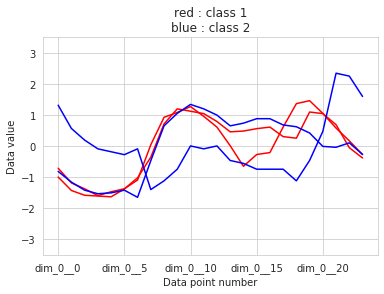

In [7]:
def plot_data_samples(X, y, sample_numbers):
    ''' 
    Plot the time series data relating to the input list of sample numbers.

    sample_numbers: list of integers
        E.g. [1, 7, 22, 42]
    '''
    
    Xt = Tabulariser().transform(X)
    unique_labels = np.unique(y).astype(int)
    num_classes = len(unique_labels)
    if num_classes<=4:
        class_colors = ['red', 'blue', 'green' , 'orange']
    else:
        class_colors = sns.color_palette(n_colors=num_classes)

    fig, ax = plt.subplots()
    for i in sample_numbers:
        print('sample', i, 'class', str(y[i]))
        color_num = y[i].astype(int) - unique_labels.min()
        Xt.iloc[i].plot(label=str(y[i]), color=class_colors[color_num])

    print('')
    plt.ylim([-3.5, 3.5])
    if num_classes<=2:
        title = class_colors[0]+' : class '+str(unique_labels[0])
        title = title + '\n'+class_colors[1]+' : class '+str(unique_labels[1])
        plt.title(title)
    ax.set_ylabel('Data value')
    ax.set_xlabel('Data point number')


plot_data_samples(X_train, y_train, [0, 1, 2, 3])

# Train a single deep neural network classifier

In [8]:
network = CNNClassifier(nb_epochs=200, verbose=False)
network.fit(X_train, y_train)
network.score(X_test, y_test)

0.9251700680272109

## Save the model to file

In [9]:
network.model.save("temp_model.h5")

# Pipeline

In [18]:
network = CNNClassifier(nb_epochs=200, verbose=False)
steps = [
            ('scaling', RowwiseTransformer(StandardScaler())),
            ('clf', network) 
        ]
pipeline = Pipeline(steps)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    hist = pipeline.fit(X_train, y_train)
    
pipeline.score(X_test, y_test)

0.9135082604470359

# Grid Search
The syntax to define a parameter grid for a pipeline is to specify for each parameter the step name, followed by \__ (a double underscore), followed by the parameter name. E.g.
To search over the nb_epochs parameter of the classifier (named 'clf') we therefore have to use "clf__nb_epochs as the key in the parameter grid dictionary.

In [20]:
param_grid = {'clf__nb_epochs': [10, 100, 200],
              'clf__batch_size': [16, 32]}
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    grid.fit(X_train, y_train)
    
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.81
Test set score: 0.80
Best parameters: {'clf__batch_size': 32, 'clf__nb_epochs': 200}
